In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import ghibtools as gh
import pandas as pd
import seaborn as sns
import pingouin as pg
import neurokit2 as nk
from params import *
from bibliotheque import *
import physio
import time
from compute_phase_freq import baseline_power_job, phase_freq_job
from preproc import convert_vhdr_job
from compute_power_at_resp import power_at_resp_job

In [3]:
concat = []
for run_key in run_keys:
    participant, session = run_key.split('_')
    power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
    concat.append(power_at_resp_participant)
power_at_resp = pd.concat(concat).reset_index(drop = True)

In [4]:
power_at_resp['log_max_eeg'] = np.log(power_at_resp['max_eeg'].values)

In [5]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_eeg','log_max_eeg']

In [6]:
power_at_resp_baselined = df_baseline(df = power_at_resp, indexes = indexes, metrics= metrics, mode = 'substract')

In [7]:
df_mask = get_df_mask_chan_signif(df = power_at_resp_baselined, chans = eeg_chans, predictor = 'session', outcome = 'log_max_eeg', subject = 'participant')

Text(0.5, 1.0, 'LogPower baseline substracted')

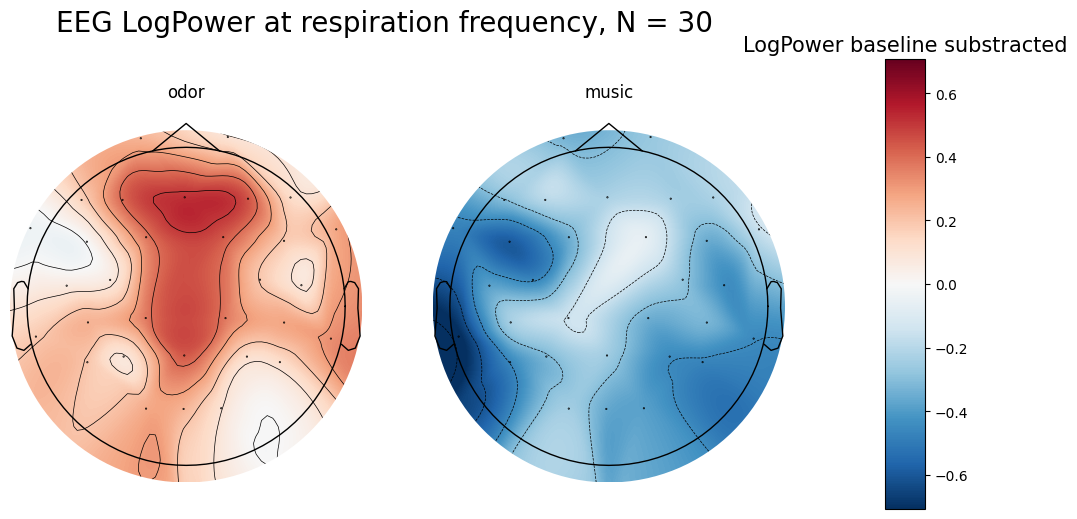

In [8]:
delta_quantile = 0.
mask_params = dict(markersize=15, markerfacecolor='y')


colname = 'log_max_eeg'

df = power_at_resp_baselined

N = power_at_resp_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG LogPower at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , 
                                  pos = pos, 
                                  names = eeg_chans, 
                                  axes = ax, 
                                  show = False, 
                                  vlim = (vmin,vmax), 
                                  mask = df_mask['mask_corr'], 
                                  mask_params = mask_params,
                                 image_interp = 'cubic')
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogPower baseline substracted',fontsize=15)
